# Dynamic Model of the Melting Process of a Cell filled with Phase Change Material (PCM)

**Objectives:**
- Analyse the melting process of a phasechange material
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from IPython.display import Image

## Description of the Physical Model
Phase change materials (PCM) are very well suited for storing thermal energy. Compared to a conventional water storage tank, a storage tank filled with PCM has a three times higher energy density. Thermal energy is stored in the material by liquefying the solid PCM. When the PCM is activated at a later time and becomes solid again, the thermal energy can be reused. 

A storage system, which consists of many small cells filled with PCM, can bring the surplus energy in the summer to the winter without any losses. 

In this project, the charging behavior of such a PCM cell is modeled dynamically. The charging power is represented as a function of the heat transfer surface. In addition, the temperature curve of the cell during charging is analyzed. 


In [2]:
Image(url= "figures/SC01.png", width=600, height=400)

## Physical analysis

### Size of the Cell

In [3]:
L = 1
B = 0.1

i = 3
j = 3

l = L/i
bl = B/j
d = 1
              # m length of the cubic room
Spcm_updown = l*d           # m² surface of the pcm 
Spcm_leftright = bl*d

Tmelt = 55
n0 = 4 # Temperature of interest

### Description of PCM

In [4]:
# used PCM: Sodium Acetate Trihydrate with a Melting Temperature of 55°C

PCM = {'Conductivity': [1.1, 1.1, 1.1],  # W/(m·K)
        'Density': [1280, 1280, 1280],        # kg/m³
        'Specific_heat': [3000, 2100, 265000],  # J/(kg·K)
        'Width': [1, 1, 1],
        # 'Surface': [Spcm_b, Spcm_b, Spcm_b], # m²
        'Slices': [3, 3, 3]}                # number of  slices
PCM_Data = pd.DataFrame(PCM, index=['Liquid', 'Solid', 'Phasechange'])

### Description of the Heat Transfer Fluid

In [5]:
Water = {'Density': 997,                      # kg/m³
       'Specific heat': 4186}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
Water = pd.DataFrame(Water, index=['Air'])

In [6]:
h = 200  # W/(m²⋅K)

## Description of the Thermal Circuit

In [7]:
Image(url= "figures/skizze_zelle.png", width=600, height=400)

This Scheme shows the Thermal Circuit of one cell filled with PCM. The heat transfer fluid is water and the PCM is sodium acetate water mixture with the melting point @ 55°C.

Heat transfert is:
- through the PCM
- convection from the flowing water to the solid/melting/liquid PCM
- temperature sources:
    - Tin is at 85°C. This is the entry temperature of the water. The outlet temperature  of the heatexchanger is not known
- flow rate sources:
    - none


### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

Conduction through the pcm material: 

Up/down:  $$𝐺_𝐶𝐷,𝑈𝐷=𝑘/𝑏⋅𝐴_𝑈𝐷=  (1.1 𝑤/𝑚𝐾)/0.033𝑚⋅0.33𝑚^2 = 11 𝑊/𝐾 $$



Right/Left: $$ 𝐺_(𝐶𝐷,𝑅𝐿)=𝑘/𝑙⋅𝐴_𝑅𝐿=0.11 𝑊/𝐾 $$

In [8]:
G_cud = PCM_Data.Conductivity['Liquid'] / bl * Spcm_updown
G_crl = float(PCM_Data.Conductivity['Liquid'] / l * Spcm_leftright)

#### Convection
The conductances 0, 6 and 7 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [9]:
# Convection
Gw = float(Water['Specific heat'])*2   #m*cp
Gwpcm = h*Spcm_updown

#### Combined Conduction & Convection

In [10]:
G1 = Gw + G_cud*2
G0 = Gw

### Thermal capacities

### Thermal capacities
#### PCM
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are of the form:

$$ C_pcm= m_pcm*c_pcm= \rho_w*c_pcm*w_pcm S $$

where:
- $m_pcm = \rho_w w_w S_w$ is the mass of the pcm, kg;
- $c_pcm$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_pcm$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_pcm$ - width of the cell, m;
- $S$ - surface area of the cell, m².

In [11]:
#Capacities
m = PCM_Data.Density['Liquid']*Spcm_leftright*l
Cpcm_solid = m*PCM_Data.Specific_heat['Solid']
Cpcm_liquid = m*PCM_Data.Specific_heat['Liquid']
Cpcm_pc = m*PCM_Data.Specific_heat['Phasechange']

### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- temperature of adjacent spaces which have controlled temperature;
- setpoint temperature.

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$



### A: incidence matrix

In [12]:
Image(url= "figures/A.png", width=600, height=400)

In [13]:
A = np.zeros([13, 9])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3,0], A[4,1], A[5,2], A[6,3] , A[7,4],A[8,3], A[9,4], A[10,5], A[11,6],A[12,8], A[12,7]= -1,-1,-1, -1, -1, -1, -1, -1, -1, -1, -1
A[3,3], A[4,4], A[5,5], A[6,4],  A[8,6], A[9,7], A[10,8], A[12,8], A[11,7], A[7,5] = 1,1,1, 1, 1, 1, 1, 1, 1, 1

In [14]:
np.set_printoptions(suppress=False)
A_Data = pd.DataFrame(A)

### G: conductance matrix

The conductance matrix of the themal circuit shown in Figure 3 is:

In [15]:
G = np.array([Gw*2, Gw, Gw, G1, G1, G1, G_crl, G_crl, G_cud, G_cud, G_cud, G_crl, G_crl])
G= np.diag(G)
np.set_printoptions(precision=3, threshold=16, suppress=True)
pd.set_option("display.precision", 1)
G_Data = pd.DataFrame(G)

In [16]:
Image(url= "figures/G.png", width=600, height=400)

### C: capacity matrix

In [17]:
C_solid = np.array([0, 0, 0, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid, Cpcm_solid])
C_solid = np.diag(C_solid)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_solid_data = pd.DataFrame(C_solid)

C_liquid = np.array([0, 0, 0, Cpcm_liquid, Cpcm_liquid, Cpcm_liquid,  Cpcm_liquid, Cpcm_liquid, Cpcm_liquid])
C_liquid = np.diag(C_liquid)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_liquid_data = pd.DataFrame(C_liquid)

Cpcm_pc = np.array([0, 0, 0, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc, Cpcm_pc])
Cpcm_pc = np.diag(Cpcm_pc)
# Uncomment next line to put 'Air' and 'Glass' capacities to zero 
# C = np.diag([0, C['Concrete'], 0, C['Insulation'], 0, 0, 0, 0])
pd.set_option("display.precision", 3)
C_pc_data = pd.DataFrame(Cpcm_pc)

𝑐_𝑠𝑜𝑙𝑖𝑑=𝑚_𝑝𝑐𝑚⋅𝑐𝑝_(𝑠 )= V⋅𝜑⋅𝑐𝑝_𝑠= 29866 𝑊/𝐾

𝑐_𝑙𝑖𝑞𝑢𝑖𝑑=𝑚_𝑝𝑐𝑚⋅𝑐𝑝_𝑙=V⋅𝜑⋅𝑐𝑝_𝑙= 42666 𝑊/𝐾

𝑐_𝑝ℎ𝑎𝑠𝑒𝑐ℎ𝑎𝑛𝑔𝑒=𝑚_𝑝𝑐𝑚⋅ℎ_𝑚𝑒𝑙𝑡=V⋅𝜑⋅ℎ_𝑚𝑒𝑙𝑡= 3768300 𝑊/𝐾

### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &0  &0  &0  &0 
\end{matrix}]^T$$

- $T_o$ is the inlet temperature of the heat transfer fluid, °C;

Since the temperature sorces $T_o$ and $T_{i,sp}$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [18]:
b = np.zeros(13)  
b[[0]] = 1 
print(b)   # branches
f = np.zeros(9)         # nodes

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 8). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

the temperature of the node = n0 will be evaluated in this model

In [19]:
y = np.zeros(9)         # nodes
y[[n0]] = 1  

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure and heat flows) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o]^T$ corresponds to branche 0; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [0]^T$;
    
- $y$ - vector of outputs is a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = n0, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

In [20]:
[As_solid, Bs_solid, Cs_solid, Ds_solid] = dm4bem.tc2ss(A, G, b, C_solid, f, y)
print('As = \n', As_solid, '\n')
print('Bs = \n', Bs_solid, '\n')
print('Cs = \n', Cs_solid, '\n')
print('Ds = \n', Ds_solid, '\n')
[As_liquid, Bs_liquid, Cs_liquid, Ds_liquid] = dm4bem.tc2ss(A, G, b, C_liquid, f, y)
[As_pc, Bs_pc, Cs_pc, Ds_pc] = dm4bem.tc2ss(A, G, b, Cpcm_pc, f, y)

As = 
 [[-0.203  0.031  0.016  0.     0.     0.   ]
 [ 0.031 -0.156  0.062  0.     0.     0.   ]
 [ 0.016  0.062 -0.11   0.     0.     0.   ]
 [ 0.     0.     0.    -0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.   ]] 

Bs = 
 [[0.156]
 [0.062]
 [0.031]
 [0.   ]
 [0.   ]
 [0.   ]] 

Cs = 
 [[0. 1. 0. 0. 0. 0.]] 

Ds = 
 [[0.]] 



## Steady-state

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:

- the inlet temperature is $T_o = 85 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [21]:
# steady state
b = np.zeros(13)        # temperature sources
b[[0]] = 85      # outdoor temperature

f = np.zeros(9)         # flow-rate sources

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [85. 85. 85. 85. 85. 85. 85. 85. 85.] °C


### System of Diferential Algebraic Equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering $\dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

For the conditions mentioned above, in steady-state, all temperatures $\theta_0 ... \theta_7$, including the indoor air temperature $\theta_6$, are equal to $T_o = 85 \, \mathrm{^\circ C}$.

In [22]:
bT = np.array([85])     # [To]
fQ = np.array([0])         # [0]
u = np.hstack([fQ])
print(f'u = {u}')

u = [0]


The steady-state value of the output of the state-space representation is:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [23]:
yss = (-Cs_solid @ np.linalg.inv(As_solid) @ Bs_solid + Ds_solid) @ u
print(f'yss = {yss} °C')

yss = [0.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [24]:

λ = np.linalg.eig(As_solid)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

dt = 3     # seconds
print(f'dt = {dt} s = {dt / 60:.0f} min')

Time constants: 
 [   4.506    5.331   16.767 2640.544 2730.64  2694.741] s 

2 x Time constants: 
 [   9.013   10.662   33.534 5281.089 5461.281 5389.483] s 

Maximum time step: 9.01 s = 0.15 min
dt = 3 s = 0 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [25]:
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

duration = 11923          # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Time constants: 
 [   4.506    5.331   16.767 2640.544 2730.64  2694.741] s 

Settling time: 10923 s = 182.0 min = 3.03 h = 0.13 days
Duration = 11923 s
Number of time steps = 3974


,time
0,0
1,3
2,6
3,9
4,12
...,...
3969,11907
3970,11910
3971,11913
3972,11916


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &0  &0  &T_o  &0  &T_o  &T_{i,sp} 
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_{i,sp}]^T$$
corresponding to branches 0, 8, 10 and 11; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3,

$$f = [\begin{matrix}
\Phi_o &0  &0  &0  &\Phi_i  &0  &\dot{Q_a} &\Phi_a 
\end{matrix}]^T$$

and

$$f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$$

corresponding to nodes 0, 4, 6, and 7.

For the thermal circuit shown in Figure 3, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $T_{i, sp} = [T_{{i, sp}(0)}, T_{{i, sp}(1)}, ..., T_{{i, sp}(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the setpoint indoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_o = [\Phi_{o(0)}, \Phi_{o(1)}, ..., \Phi_{o(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_i = [\Phi_{i(0)}, \Phi_{i(1)}, ..., \Phi_{i(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the indoor surface of the wall at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\dot{Q}_a = [\dot{Q}_{a(0)}, \dot{Q}_{a(1)}, ..., \dot{Q}_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the auxiliary heat gains (i.e., occupants, electrical devices, etc.) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.
- $\Phi_a = [\Phi_{a(0)}, \Phi_{a(1)}, ..., \Phi_{a(n-1)}]^T$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the glass at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]^T$.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, $T_{i,sp} = 20 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [26]:
u = 80*np.ones([1, n])      # Tisp = 20 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973
0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,...,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0


#### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [27]:
n_s = As_solid.shape[0]                      # number of state variables
θ_exp = 20*np.ones([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = 20*np.ones([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    if θ_exp[n0-3, k] < Tmelt-1:
        θ_exp[:, k + 1] = (I + dt * As_solid) @\
            θ_exp[:, k] + dt * Bs_solid @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_solid) @\
            (θ_imp[:, k] + dt * Bs_solid @ u[:, k])
    if θ_exp[n0-3, k] > Tmelt+1:
        θ_exp[:, k + 1] = (I + dt * As_liquid) @\
            θ_exp[:, k] + dt * Bs_liquid @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_liquid) @\
            (θ_imp[:, k] + dt * Bs_liquid @ u[:, k])
    else: 
        θ_exp[:, k + 1] = (I + dt * As_pc) @\
            θ_exp[:, k] + dt * Bs_pc @ u[:, k]
        θ_imp[:, k + 1] = np.linalg.inv(I - dt * As_pc) @\
            (θ_imp[:, k] + dt * Bs_pc @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [28]:
y_exp = Cs_solid @ θ_exp + Ds_solid @  u
y_imp = Cs_solid @ θ_imp + Ds_solid @  u

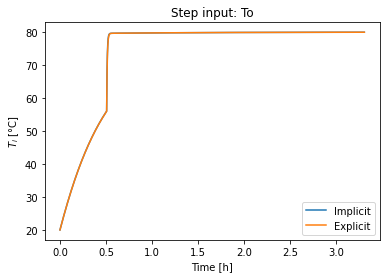

In [29]:

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()
